In [1]:
%reset -f

In [127]:
import os
ROOT_PATH = os.path.abspath(".").split("main")[0]
MAIN_PATH = ROOT_PATH + "main/"
EXPORT_PATH = ROOT_PATH + "exports/"
DATA_PATH = ROOT_PATH + "data/"
SAVE_PATH = ROOT_PATH + "save/"

Import some important libraries.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from cognite.v05.assets import get_assets
from cognite.v05.assets import get_asset
from cognite.v05.timeseries import get_datapoints_frame

In [26]:
# Use the seaborn theme as this looks better than the standard matplotlib
import seaborn as sns
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

Authenticate session with Cognite API

In [8]:
# authenticate session with Cognite API
from cognite.config import configure_session
from credentials import COGNITE_API_KEY
configure_session(COGNITE_API_KEY, 'publicdata')

In [162]:
input_tags = ['VAL_23-FT-92512:X.Value', 'VAL_23-PT-92532:X.Value', 'VAL_23-TT-92533:X.Value']
control_tags = ['VAL_23_ZT_92543:Z.X.Value', 'VAL_23_ZT_92538:Z.X.Value', 'VAL_23-KA-9101_ASP:VALUE']
output_tags = ['VAL_23-FT-92537-01:X.Value', 'VAL_23-TT-92539:X.Value', 'VAL_23-PT-92539:X.Value']

feature_tags = input_tags + control_tags
target_tags = output_tags

In [165]:
def load_data():
    start = datetime(2018, 10, 1)
    end = datetime(2018, 10, 5)
    time_interval_seconds = 60
    granularity = str(time_interval_seconds) + 's'
    aggregates = ['avg']

    data = get_datapoints_frame(feature_tags + target_tags,
                                start=start,
                                end=end,
                                granularity=granularity,
                                aggregates=aggregates)


    # extract column names for features and targets
    new_target_tags = [label for label in list(data.columns) if
                       any([label.startswith(var_name) for var_name in target_tags])]
    new_feature_tags = [label for label in list(data.columns) if
                        not any([label.startswith(var_name) for var_name in target_tags])]
    if 'timestamp' in new_feature_tags:
        new_feature_tags.remove('timestamp')

    return data, {'target_tags': new_target_tags, 'feature_tags': new_feature_tags}

data, tags = load_data()

In [166]:
print(data.shape)
print(list(data))
data.head()

(5757, 10)
['timestamp', 'VAL_23-FT-92512:X.Value|average', 'VAL_23-PT-92532:X.Value|average', 'VAL_23-TT-92533:X.Value|average', 'VAL_23_ZT_92543:Z.X.Value|average', 'VAL_23_ZT_92538:Z.X.Value|average', 'VAL_23-KA-9101_ASP:VALUE|average', 'VAL_23-FT-92537-01:X.Value|average', 'VAL_23-TT-92539:X.Value|average', 'VAL_23-PT-92539:X.Value|average']


,timestamp,VAL_23-FT-92512:X.Value|average,VAL_23-PT-92532:X.Value|average,VAL_23-TT-92533:X.Value|average,VAL_23_ZT_92543:Z.X.Value|average,VAL_23_ZT_92538:Z.X.Value|average,VAL_23-KA-9101_ASP:VALUE|average,VAL_23-FT-92537-01:X.Value|average,VAL_23-TT-92539:X.Value|average,VAL_23-PT-92539:X.Value|average
0,1538352000000,90150.912363,2.705453,32.631535,40.832822,84.588136,9026.448126,161530.764761,124.146368,12.416864
1,1538352060000,91392.967933,2.734958,32.629505,39.413760,84.494341,8945.048912,160139.994159,124.015466,12.617776
2,1538352120000,87210.320438,2.729676,32.622665,40.440379,84.248860,8854.175063,159584.193380,124.184569,12.630701
3,1538352180000,90735.311816,2.783820,32.550695,39.880508,83.044241,8928.131728,161869.584221,124.264947,12.815438
4,1538352240000,90505.384761,2.790743,32.538377,39.689738,83.537664,9100.428519,161252.541858,124.427919,12.841096


### Data scaling
The data is now scaled with standardization, i.e. subtracting mean and dividing by standard deviance for each of the respective features. 

In [167]:
if 'timestamp' in data.columns:
    ts = data.timestamp
    T = pd.to_datetime(data.timestamp,unit="ms")
    data = data.drop(['timestamp'], axis=1)

train_size = int(0.6 * len(data))
valid_size = int(0.2 * len(data))
test_size = len(data) - (train_size + valid_size)

# calculate the mean and standard deviation of the training set
# use these values to standardize the training, validation and testing data
means = np.mean(data[:train_size]).tolist() # will skip NA values 
stds = np.std(data[:train_size]).tolist() # will skip NA values

# standardize the data
scaled_data = data - means
scaled_data /= stds

# verify that mean is approx 0 and std approx 1
print("Mean values")
print(scaled_data.mean())
print("\nStandard deviation values")
print(scaled_data.std())

Mean values
VAL_23-FT-92512:X.Value|average       0.071110
VAL_23-PT-92532:X.Value|average      -0.107057
VAL_23-TT-92533:X.Value|average       0.584950
VAL_23_ZT_92543:Z.X.Value|average    -0.003392
VAL_23_ZT_92538:Z.X.Value|average    -0.035529
VAL_23-KA-9101_ASP:VALUE|average      0.069437
VAL_23-FT-92537-01:X.Value|average    0.135790
VAL_23-TT-92539:X.Value|average       0.332388
VAL_23-PT-92539:X.Value|average       0.008220
dtype: float64

Standard deviation values
VAL_23-FT-92512:X.Value|average       1.020198
VAL_23-PT-92532:X.Value|average       0.947536
VAL_23-TT-92533:X.Value|average       1.199889
VAL_23_ZT_92543:Z.X.Value|average     0.959086
VAL_23_ZT_92538:Z.X.Value|average     0.946525
VAL_23-KA-9101_ASP:VALUE|average      0.910106
VAL_23-FT-92537-01:X.Value|average    0.956936
VAL_23-TT-92539:X.Value|average       1.062644
VAL_23-PT-92539:X.Value|average       0.985058
dtype: float64


### Handling missing data points and NA values

Now, we must handle NA values. They have until now been ignored and have not affected the scaling of the data in any way. They will be removed by forward- and backwards filling. 

In [168]:
print(scaled_data.isna().sum()) # the number of NA values for each of the predictors 

scaled_data = scaled_data.fillna(method='ffill')
scaled_data = scaled_data.fillna(method='backfill')

print(scaled_data.isna().sum()) # verify that there are no NA values in the dataset

VAL_23-FT-92512:X.Value|average         0
VAL_23-PT-92532:X.Value|average         0
VAL_23-TT-92533:X.Value|average        61
VAL_23_ZT_92543:Z.X.Value|average       4
VAL_23_ZT_92538:Z.X.Value|average     413
VAL_23-KA-9101_ASP:VALUE|average       15
VAL_23-FT-92537-01:X.Value|average      0
VAL_23-TT-92539:X.Value|average        64
VAL_23-PT-92539:X.Value|average         0
dtype: int64
VAL_23-FT-92512:X.Value|average       0
VAL_23-PT-92532:X.Value|average       0
VAL_23-TT-92533:X.Value|average       0
VAL_23_ZT_92543:Z.X.Value|average     0
VAL_23_ZT_92538:Z.X.Value|average     0
VAL_23-KA-9101_ASP:VALUE|average      0
VAL_23-FT-92537-01:X.Value|average    0
VAL_23-TT-92539:X.Value|average       0
VAL_23-PT-92539:X.Value|average       0
dtype: int64


In [175]:
(tags['feature_tags']+tags['target_tags']).index('VAL_23-FT-92537-01:X.Value|average')

6

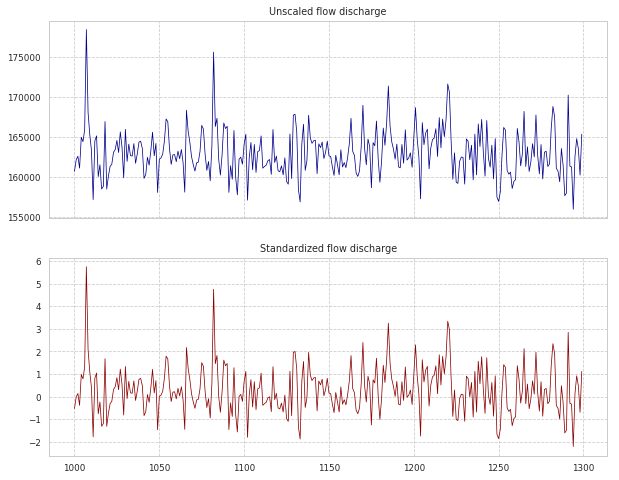

In [177]:
# visualise the discharge flow before and after scaling
tagname = 'VAL_23-FT-92537-01:X.Value|average'
inds = np.arange(1000,1300,1)

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(10,8))
ax1.plot(data[tagname][inds], linewidth=0.75, color="darkblue")
ax1.set_title("Unscaled flow discharge")
ax2.plot(scaled_data[tagname][inds], linewidth=0.75, color="darkred")
ax2.set_title("Standardized flow discharge")
plt.show()



### Split to training, validation and testing sets
The data is now split into training, validation and testing sets with 60-20-20. 
Furthermore, they are converted to numpy arrays. 

In [170]:
df2np = scaled_data.values
df2np_train = df2np[:train_size]
df2np_valid = df2np[train_size:-test_size]
df2np_test = df2np[-test_size:]

print("=========== SUMMARY ===========")
print("Total number of observations : {}".format(len(df2np)))
print("Size of train+valid+test     : {}".format(len(df2np_train) + len(df2np_valid) + len(df2np_test)))
print("Size of training set         : {}".format(len(df2np_train)))
print("Size of validation set       : {}".format(len(df2np_valid)))
print("Size of testing set          : {}".format(len(df2np_test)))

=========== SUMMARY ===========
Total number of observations : 5757
Size of train+valid+test     : 5757
Size of training set         : 3454
Size of validation set       : 1151
Size of testing set          : 1152


### Plots of the data
Plot of the discharge flow for the testing, training and validation sets. 

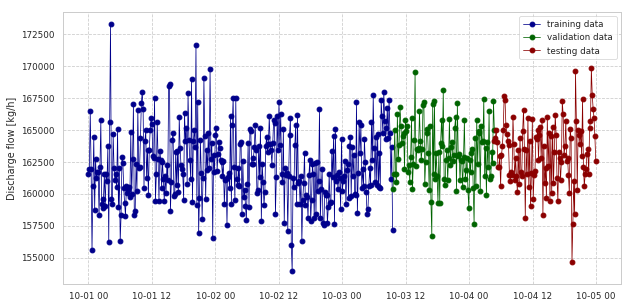

In [171]:
tagname = 'VAL_23-FT-92537-01:X.Value|average' # discharge flow
delta = 10

plt.figure(figsize=(10,5))
plt.plot_date(x=T[:train_size:delta], y=data[tagname][:train_size:delta], 
              linewidth = 0.75, color="darkblue", linestyle="-", label="training data")
plt.plot_date(x=T[train_size:-test_size:delta], y=data[tagname][train_size:-test_size:delta], 
              linewidth = 0.75, color="darkgreen", linestyle="-", label="validation data")
plt.plot_date(x=T[-test_size::delta], y=data[tagname][-test_size::delta], 
              linewidth = 0.75, color="darkred", linestyle="-", label="testing data")
plt.ylabel("Discharge flow [kg/h]")
plt.legend(frameon=True)
plt.show()

### Store the files
The datasets are now saved to respective files such that they easily can be worked with in other files

In [172]:
# save the complete datasets as pickled dataframes
data.to_pickle(DATA_PATH + "unprocessed_data.pkl")
scaled_data.to_pickle(DATA_PATH + "scaled_data.pkl")

# save the standardized data sets
np.save(DATA_PATH + "standardized_complete.npy", df2np)
np.save(DATA_PATH + "standardized_train.npy", df2np_train)
np.save(DATA_PATH + "standardized_valid.npy", df2np_valid)
np.save(DATA_PATH + "standardized_test.npy", df2np_test)

# save metadata; headers, means, standard deviations
np.save(DATA_PATH + "feature_tags.npy", tags['feature_tags'])
np.save(DATA_PATH + "target_tags.npy", tags['target_tags'])
np.save(DATA_PATH + "means.npy", means)
np.save(DATA_PATH + "stds.npy", stds)